# Predicting the sale price of a house in Ames, Iowa

In this project, we will attempt to predict the sale price of a house based on housing data for the city of Ames, Iowa. The data was collected to produce a good set of data for statistics education [[1]](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627). The learning model that we will be using is a linear regression model with both numerical and categorical features. Before training the model, the crucial steps of data cleaning and feature selection will be performed. Finally, we will test the model using k-fold cross-validation.

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import data and display the first five rows
houses = pd.read_csv('AmesHousing.tsv', delimiter='\t')
houses.head()


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Data cleaning

Let's start by transforming the dataframe into something more useful. Details in code comments.

In [121]:
from pandas.api.types import is_numeric_dtype

def transform_features(df):
    '''Clean housing dataframe.'''

    # Ensure we are not modifying input dataframe
    df = df.copy()
    
    # Transform years column into "years until remod", which carries more info
    df['years_until_remod'] = df['Year Remod/Add'] - df['Year Built']
    
    # Transform years column into age of house which carries more info
    df['house_age'] = df['Yr Sold'] - df['Year Built']
    df['garage_age'] = df['Yr Sold'] - df['Garage Yr Blt']
       
    # Transform Y/N values into True/False
    map_YN = {'Y':1, 'N':0}
    df['Central Air'] = df['Central Air'].replace(map_YN).astype(int)
        
        
    ## Drop columns that leak info about the final sale
    df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    
    # Drop non-relevant columns
    cols_to_drop = [
        'PID',  # doesn't describe house
        'Order', # doesn't describe house
        'MS SubClass', # BldgType and HouseStyle transmit the same info
        'Garage Cars',  # garage area transmits the same info
        'Misc Val', # not easy to transform
        'Condition 1', # not easy to transform
        'Condition 2', # not easy to transform
        'BsmtFin Type 1', # not easy to transform
        'BsmtFin Type 2', # not easy to transform
        'Exterior 1st', # not easy to transform
        'Exterior 2nd', # not easy to transform
        'Year Built', # converted to age earlier
        'Year Remod/Add', # converted to age earlier
        'Garage Yr Blt', # converted to age earlier
    ]
    df = df.drop(cols_to_drop, axis=1)
    

    # Remove columns missing more than 5% values
    nulls = df.isnull().sum()
    df = df.drop(nulls[nulls > df.shape[0]*0.05].index, axis=1)
    
    # Replace columns with less than 5% missing values by mean or mode
    cols_less_than_5per = nulls[(nulls < df.shape[0]*0.05) & (nulls > 0)].index
    for col in cols_less_than_5per:
        if is_numeric_dtype(df[col]):
            df[col] = df[col].fillna(df[col].mean())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])
    
    
    return df

houses_clean = transform_features(houses)
houses_clean.head()

,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Bldg Type,...,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,SalePrice,years_until_remod,house_age
0,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,1Fam,...,P,210,62,0,0,0,0,215000,0,50
1,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,1Fam,...,Y,140,0,0,0,120,0,105000,0,49
2,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,1Fam,...,Y,393,36,0,0,0,0,172000,0,52
3,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,1Fam,...,Y,0,0,0,0,0,0,244000,0,42
4,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,1Fam,...,Y,212,34,0,0,0,0,189900,1,13


## Feature selection

Now that the dataset is clean, we will begin the process of choosing the features that will describe our target (SalePrice) the best. The function select_features takes the clean housing dataset and removes columns with features that we want to get rid of.

In [122]:
def select_features(df):
    
    # Ensure we are not modifying input dataframe
    df = df.copy()
    
    df_num = df.select_dtypes(include=['number'])
    # Drop numerical features that are actually categorical (will be treated in further step)
    df_num = df_num.drop(['Overall Qual', 'Overall Cond'], axis=1) 
    # Calculate correlation between numerical columns and Sale Price
    corr = df_num.corr()['SalePrice'].abs().sort_values()
    # Drop columns with correlation less than threshold_corr
    threshold_corr = 0.4 # arbitrary value
    uncorrelated_features = corr[corr < threshold_corr].index
    df = df.drop(uncorrelated_features, axis=1)
    
    # Transform categorical variables into dummies
    categorical_cols = [
        'MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
        'Lot Config', 'Land Slope', 'Neighborhood', 'Bldg Type', 
        'House Style', 'Overall Qual', 'Overall Cond', 'Roof Style',
        'Roof Matl', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond',
        'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
        'Heating', 'Heating QC', 'Electrical', 'Kitchen Qual',
        'Functional', 'Paved Drive',
    ]
    for col in categorical_cols:
        # Check for uniqueness (number of unique values higher than 10)
        low_uniqueness = (len(df[col].unique()) > 10)
        # Check for categories with low variance (one value taking more than 90%)
        low_variance = (df[col].value_counts(normalize=True).max() > 0.9)
        
        if low_uniqueness or low_variance:
            # Don't create a dummy dataframe and move directly to column drop
            pass
        else:
            # Build dummy columns
            dummies = pd.get_dummies(df[col], prefix=col)
            # Append to original dataframe
            df = pd.concat([df, dummies], axis=1)

        # Delete original column
        df.drop(col, axis=1, inplace=True)
    return df

houses_select = select_features(houses_clean)
houses_select.head()

,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Area,SalePrice,...,Heating QC_Ex,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_Po,Kitchen Qual_TA
0,112.0,639.0,1080.0,1656,1656,1,7,2,528.0,215000,...,0,1,0,0,0,0,0,0,0,1
1,0.0,468.0,882.0,896,896,1,5,0,730.0,105000,...,0,0,0,0,1,0,0,0,0,1
2,108.0,923.0,1329.0,1329,1329,1,6,0,312.0,172000,...,0,0,0,0,1,0,0,1,0,0
3,0.0,1065.0,2110.0,2110,2110,2,8,2,522.0,244000,...,1,0,0,0,0,1,0,0,0,0
4,0.0,791.0,928.0,928,1629,2,6,1,482.0,189900,...,0,0,1,0,0,0,0,0,0,1


## Train and test model

For this statistical learning we choose a simple linear regression model, already implemented in scikit-learn. Our train_and_test function takes k as a parameter, where k is the number of folds we want from cross-validation.

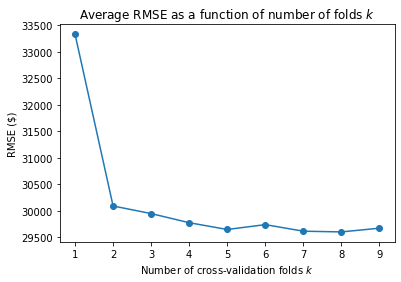

In [146]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

def train_and_test(df, k=1):
    '''
    df: housing dataframe
    k: number of folds for cross-validation. For k=1, do typical train(80%) and test(20%) holdout validation.
    '''
    
    # Ensure we are not modifying input dataframe
    df = df.copy()
    
    # Fix model target as the house sale price
    target = 'SalePrice'
    # Select all columns except target as features (feature selection already happened)
    features = list(df.columns)
    features.remove(target)
    
    lr = LinearRegression()
    
    if k==1:
        np.random.seed(1)
        indices = np.random.permutation(df.shape[0])
        df_shuffle = df.iloc[indices]
        N = int(df.shape[0] * .8)
        train = df_shuffle.iloc[:N]
        test = df_shuffle.iloc[N:]
        lr.fit(train[features], train[target])
        predictions = lr.predict(test[features])
        rmse = np.sqrt(mean_squared_error(test[target], predictions))
        
    elif k>1:
        # Separate the dataset into k folds
        kf = KFold(k, shuffle=True, random_state=1)
        mses = cross_val_score(lr, 
                               df[features], 
                               df[target], 
                               scoring='neg_mean_squared_error',
                               cv=kf)
            
        rmse = np.sqrt(np.mean(np.abs(mses)))
    else:
        raise RuntimeError('k < 1 is not a valid number of folds for cross-validation.')
    
    return rmse

k_list = list(range(1,10))
rmse_list = []
for k in k_list:
    rmse = train_and_test(houses_select, k=k)
    rmse_list.append(rmse)
    
plt.plot(k_list, rmse_list, 'o-')
plt.xlabel('Number of cross-validation folds $k$')
plt.ylabel('RMSE ($)')
plt.title('Average RMSE as a function of number of folds $k$')
plt.show()

Looks like 5 folds reaches a plateau for RMSE. The resulting RMSE value is 29650$.

In [150]:
houses['SalePrice'].std()

79886.69235666493

The standard deviation of sale price was 79887$ originally, so we made big accuracy gains.

# Conclusion

In this project, we applied a linear regression learning model to a data set of housing sales that occured in Ames, Iowa between 2006 and 2010. The target for prediction was the sale price of the house. First of all, we cleaned the data set and selected the most relevant features based on correlation with sale price. We then applied the linear model and tested the accuracy of the results using a k-fold cross-validation technique. We found the optimal number of folds to be k=5.

We could lower the root mean squared error (RMSE) for predicting the sale price of house to 29650$$, starting from a standard deviation of 79887$ in sale prices. There are many parameters that could be further optimized, starting with feature selection. The thresholds for uniqueness and variance in categorical variables, as well as correlation factors for numerical variables, could be tweaked further to see if bringing more or less features in affects the RMSE at all. 

